<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LGBM-Regressor" data-toc-modified-id="LGBM-Regressor-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LGBM Regressor</a></span></li><li><span><a href="#Gradient-Boosting-Regressor" data-toc-modified-id="Gradient-Boosting-Regressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Gradient Boosting Regressor</a></span></li><li><span><a href="#CatBoost-Regressor" data-toc-modified-id="CatBoost-Regressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoost Regressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from tqdm.auto import tqdm


#%matplotlib inline

In [2]:
RND = 12345

In [3]:
df = pd.read_csv('taxi.csv', 
                 index_col='datetime', parse_dates=[0])

In [4]:
df.sample(n=5)

,num_orders
datetime,
2018-04-19 14:30:00,8
2018-06-30 18:50:00,9
2018-04-19 12:10:00,10
2018-06-08 17:00:00,11
2018-06-04 10:50:00,27


In [5]:
df.index.is_monotonic

True

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


## Анализ

In [7]:
df = df.sort_index()
df_day = df.resample('1D').sum() # Создадим для провередения анализа дополнительный датасет
df = df.resample('1H').sum() #Ресемплирование данных по одному часу


Цель задания - прогнозирование количества заказов такси на следующий час на основе моделей машинного обучения. Разложим данные на три составляющие: тренд, сезонность и остаток. Построим графики последнего месяца временного ряда и проанализируем данные.

__Анализ временного ряда при суммировании за один час__

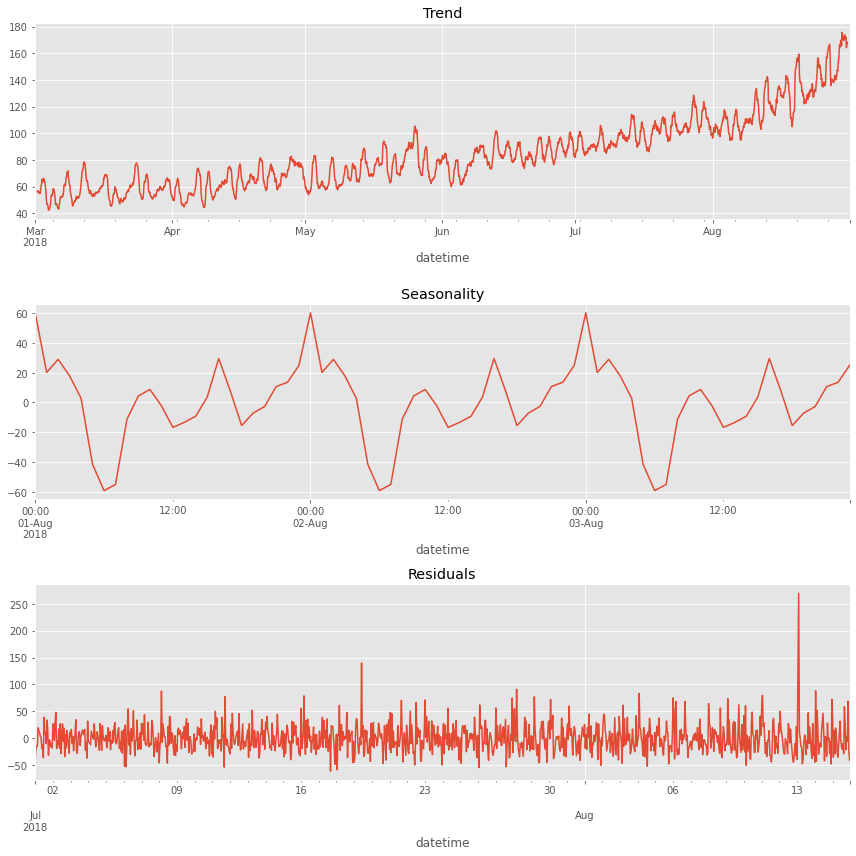

In [8]:
plt.style.use('ggplot')
decomposed = seasonal_decompose(df)
plt.figure(figsize=(12, 12))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-08-01':'2018-08-03'].plot(ax=plt.gca())

plt.title('Seasonality')
plt.subplot(313)
decomposed.resid['2018-07-01':'2018-08-15'].plot(ax=plt.gca())

plt.title('Residuals')
plt.tight_layout()

Анализ графиков позволяет сделать следующие выводы:
- линия тренда имеет тенденцию к возрастанию числа заказов, причем особенно значительный рост наблюдается в августе, что визуально напоминает квадратичную линию тренда;
- сезонность в течение суток имеет явный повторяющийся характер. Необычно, но максимум суточной активности приходится на полночь, также имеется утренние и вечерние пики. Наибольший спад заказов ночью, что ожидаемо. 
- остаток декомпозиции имеет редкие, но значительные всплески активности.

__Анализ временного ряда при суммировании за один день__

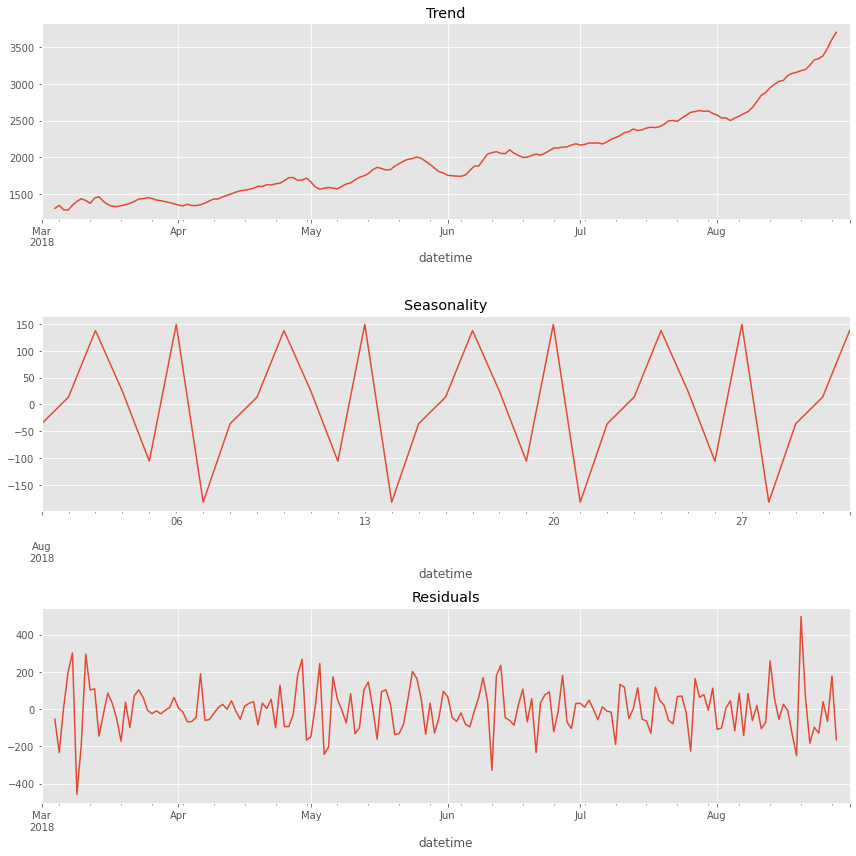

In [9]:
plt.style.use('ggplot')
decomposed = seasonal_decompose(df_day)
plt.figure(figsize=(12, 12))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-08-01':].plot(ax=plt.gca())

plt.title('Seasonality')
plt.subplot(313)
decomposed.resid['2018-03-01':].plot(ax=plt.gca())

plt.title('Residuals')
plt.tight_layout()

Из анализа графиков при усреднении за один день можно сделать следующие выводы:
•	на линии тренда более четка видна нелинейность зависимости, поэтому можно сразу отбросить линейную регрессию, так как она не обеспечит учет особенностей рассматриваемого случая. Применение полиномиальной регрессии зачастую приводит к переобучению моделей и тоже редко применяется;
•	на графике сезонности чётко виден недельный тренд;
•	график остатков позволяет сделать выводы о том, что имеется определенные события, которые существенно влияют на количество заказов, в целом ряд остатков выглядит относительно стационарным, но со значительной дисперсией и примерно нулевым средним.


Выводы из анализа:
•	наблюдается несколько периодов: дневной и недельный (может быть есть и более длинные сезонные циклы, но период анализа не очень большой, да и условия ведения бизнеса могут меняться);
•	имеется явный нелинейный тренд на увеличения заказов. Исходя из этого применение линейных моделей нецелесообразно.


## Обучение

In [10]:
train, test = train_test_split(df, shuffle=False, test_size=0.2, random_state = RND)
train = train.dropna()
print('Проверка минимального и максимального значений индексов для тренировочного датасета: ', 
      train.index.min(), train.index.max())
print('Проверка минимального и максимального значений индексов для тестового датасета: ', 
      test.index.min(), test.index.max())

Проверка минимального и максимального значений индексов для тренировочного датасета:  2018-03-01 00:00:00 2018-07-26 03:00:00
Проверка минимального и максимального значений индексов для тестового датасета:  2018-07-26 04:00:00 2018-08-31 23:00:00


In [11]:
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
rmse_base =  mean_squared_error(test['num_orders'], pred_previous) ** 0.5
print("RMSE на основе прогнозирования по предыдущему значению:", round(rmse_base, 3))
pred_mean = np.ones(test.shape) * train['num_orders'].mean()
print("RMSE на основе прогнозированию по среднему:", 
      mean_squared_error(test['num_orders'], pred_mean) ** 0.5)

RMSE на основе прогнозирования по предыдущему значению: 53.368
RMSE на основе прогнозированию по среднему: 74.42015786913375


Значение метрики RMSE на тестовой выборке должно быть не больше 48 по условию проекта. Прогнозирование на основе предыдущего значения показывает чуть лучшее значение чем на основе среднего, но в целом можно сказать, что качество таких примитивных моделей не очень высокое.

In [12]:
def make_features(data, max_lag, week_lag, rolling_mean_size_1, rolling_mean_size_2, rolling_mean_size_3):
    df = data.copy()
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
        
    df['week_lag'] = df['num_orders'].shift(week_lag)
    df['rolling_mean_1'] = df['num_orders'].shift().rolling(rolling_mean_size_1).mean()
    df['rolling_mean_2'] = df['num_orders'].shift().rolling(rolling_mean_size_2).mean()
    df['rolling_mean_3'] = df['num_orders'].shift().rolling(rolling_mean_size_3).mean()
    return df

In [13]:
df = make_features(df, 49, 24*7, 24, 24*7, 24*30)
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()
X_train = train.drop('num_orders', axis = 1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis = 1)
y_test = test['num_orders']

In [14]:
def prediction(model, feat, targ):
    
    pred = model.predict(feat)
    rmse = mean_squared_error(pred, targ)**0.5
    
    return(rmse)

### LGBM Regressor

In [15]:
model_lgb = lgb.LGBMRegressor(random_state = RND)

In [16]:
%%time
model_lgb.fit(X_train, y_train)

CPU times: user 1.68 s, sys: 39.8 ms, total: 1.72 s
Wall time: 1.65 s


LGBMRegressor(random_state=12345)

In [17]:
%%time
prediction(model_lgb, X_test, y_test)

CPU times: user 46.1 ms, sys: 2.49 ms, total: 48.5 ms
Wall time: 89.3 ms


39.382345091691164

In [18]:
res = {
    'model_name':pd.Series(['LGBMRegressor','GradBoost','CatBoost']),
    'training_time':pd.Series([1.55]),
    'prediction_test_time':pd.Series([0.11]), 
    'rmse_test':pd.Series([39.38])}

results = pd.DataFrame(res)
results

,model_name,training_time,prediction_test_time,rmse_test
0,LGBMRegressor,1.55,0.11,39.38
1,GradBoost,NaN,NaN,NaN
2,CatBoost,NaN,NaN,NaN


### Gradient Boosting Regressor

In [19]:
model_gbr = GradientBoostingRegressor(random_state = RND)

In [20]:
%%time
model_gbr.fit(X_train, y_train)

CPU times: user 2.86 s, sys: 0 ns, total: 2.86 s
Wall time: 2.87 s


GradientBoostingRegressor(random_state=12345)

In [21]:
%%time
prediction(model_gbr, X_test, y_test)

CPU times: user 5.87 ms, sys: 0 ns, total: 5.87 ms
Wall time: 4.52 ms


41.845716845058604

In [22]:
results.loc[1, 'training_time'] = 2.52 
results.loc[1, 'prediction_test_time'] = 0.004
results.loc[1,'rmse_test'] = 41.8

results

,model_name,training_time,prediction_test_time,rmse_test
0,LGBMRegressor,1.55,0.110,39.38
1,GradBoost,2.52,0.004,41.80
2,CatBoost,NaN,NaN,NaN


### CatBoost Regressor

In [23]:
model_cb = CatBoostRegressor(random_state = RND)


In [24]:
%%time
model_cb.fit(X_train, y_train)

Learning rate set to 0.049333
0:	learn: 37.8844685	total: 65.4ms	remaining: 1m 5s
1:	learn: 36.9137800	total: 78.1ms	remaining: 39s
2:	learn: 35.9418316	total: 91.5ms	remaining: 30.4s
3:	learn: 35.0774487	total: 105ms	remaining: 26.2s
4:	learn: 34.2428844	total: 118ms	remaining: 23.4s
5:	learn: 33.4981529	total: 131ms	remaining: 21.7s
6:	learn: 32.7755412	total: 144ms	remaining: 20.4s
7:	learn: 32.1211707	total: 157ms	remaining: 19.4s
8:	learn: 31.4585473	total: 170ms	remaining: 18.7s
9:	learn: 30.8745587	total: 183ms	remaining: 18.1s
10:	learn: 30.3118392	total: 197ms	remaining: 17.7s
11:	learn: 29.8032748	total: 210ms	remaining: 17.3s
12:	learn: 29.2867635	total: 222ms	remaining: 16.9s
13:	learn: 28.7880798	total: 235ms	remaining: 16.6s
14:	learn: 28.3366476	total: 248ms	remaining: 16.3s
15:	learn: 27.8836072	total: 262ms	remaining: 16.1s
16:	learn: 27.4835405	total: 275ms	remaining: 15.9s
17:	learn: 27.0952214	total: 288ms	remaining: 15.7s
18:	learn: 26.7279188	total: 300ms	remainin

In [25]:
%%time
prediction(model_cb, X_test, y_test)

CPU times: user 6.49 ms, sys: 113 µs, total: 6.6 ms
Wall time: 5.38 ms


38.269039006958735

In [26]:
results.loc[2, 'training_time'] = 12.5 
results.loc[2, 'prediction_test_time'] = 0.004
results.loc[2,'rmse_test'] = 38.27


## Тестирование

In [27]:
results

,model_name,training_time,prediction_test_time,rmse_test
0,LGBMRegressor,1.55,0.110,39.38
1,GradBoost,2.52,0.004,41.80
2,CatBoost,12.50,0.004,38.27


Из анализа таблицы можно сделать вывод, что все рассмотренные модели показали удовлетворительные результаты и соответствуют требованиям (Значение метрики RMSE на тестовой выборке должно быть не больше 48). Время обучения и время прогнозирования являются дополнительными параметрами оценки качества моделей, но требования по этим параметрам не задавались. Сравнение с примитивными моделями показывает существенное улучшение качества моделей.

In [28]:
true_pred = pd.DataFrame({ 
    'y_true' : y_test,
    'y_pred' : model_cb.predict(X_test)
    })

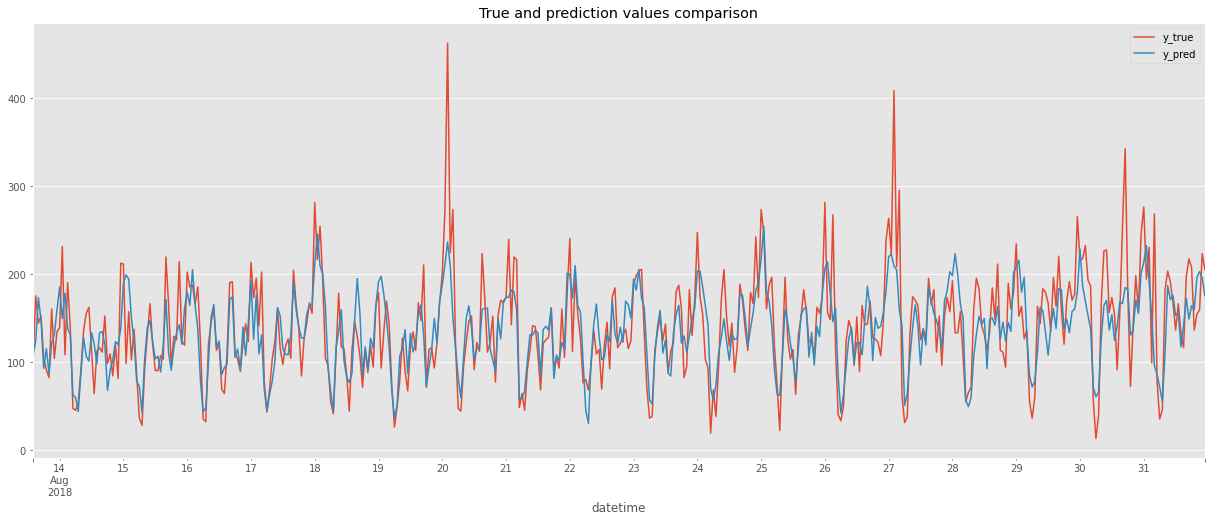

In [29]:
true_pred.plot(figsize=(21,8), title='True and prediction values comparison');

Сравнение реальных значений и спрогнозированных показывает, что в целом были определены основные особенности временного ряда, но также имеются и выбросы, которые могут определятся другими факторами, например, праздниками или другими особенными днями.

In [30]:
class plotter:
 
    
    def plot_feature_importance(self,importance,names,model_type):

        feature_importance = np.array(importance)
        feature_names = np.array(names)

        #Create a DataFrame using a Dictionary
        data={'feature_names':feature_names,'feature_importance':feature_importance}
        fi_df = pd.DataFrame(data)

        #Sort the DataFrame in order decreasing feature importance
        fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

        #Define size of bar plot
        plt.figure(figsize=(10,8))
        #Plot Searborn bar chart
        sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
        #Add chart labels
        plt.title(model_type + 'FEATURE IMPORTANCE')
        plt.xlabel('FEATURE IMPORTANCE')
        plt.ylabel('FEATURE NAMES')
        
        
ds = plotter()

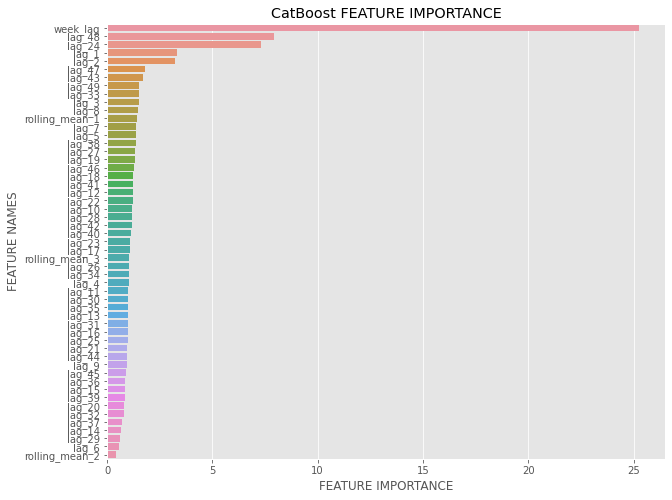

In [31]:
#Посмотрим feature importance у модели lightgbm
ds.plot_feature_importance(model_cb.feature_importances_,X_test.columns,'LGBMRegressor ')

На графике представлено сравнение важности различных колонок для прогнозирования временного ряда. Наибольшее значение имеют недельный, суточный и двухсуточный цикл(сезон), а также наиболее близкие значения к прогнозируемой величине.

## Общий вывод

Выводы из анализа:
- наблюдается несколько периодов: дневной и недельный (может быть есть и более длинные сезонные циклы, но период анализа не очень большой, да и условия ведения бизнеса могут меняться);
- имеется явный нелинейный тренд на увеличения заказов. Исходя из этого применение линейных моделей нецелесообразно.
- значение метрики RMSE на тестовой выборке должно быть не больше 48 по условию проекта. Прогнозирование на основе предыдущего значения показывает чуть лучшее значение чем на основе среднего, но в целом можно сказать, что качество таких примитивных моделей не очень высокое.

- из анализа таблицы можно сделать вывод, что все рассмотренные модели показали удовлетворительные результаты и соответствуют требованиям (Значение метрики RMSE на тестовой выборке должно быть не больше 48). Время обучения и время прогнозирования являются дополнительными параметрами оценки качества моделей, но требования по этим параметрам не задавались. Сравнение с примитивными моделями показывает существенное улучшение качества моделей.
- сравнение реальных значений и спрогнозированных показывает, что в целом были определены основные особенности временного ряда, но также имеются и выбросы, которые могут определятся другими факторами, например, праздниками или другими особенными днями.
- на графике представлено сравнение важности различных колонок для прогнозирования временного ряда. Наибольшее значение имеют недельный, суточный и двухсуточный цикл(сезон), а также наиболее близкие значения к прогнозируемой величине.

__Подбор гиперпараметров не проводил по следующей причине: величина RSME является величиной случайной, распределенная скорее всего по нормальному закону. Поэтому перебрав множество параметров можно получить лучший результат, но он будет получен не из-за того, что лучшая модель действительно лучше прогнозирует, а по причине случайности RSME. Я перебрал разные гиперпараметры и значимого улучшения не получил.__
